In [1]:
import numpy as np
import matplotlib.pyplot as plt

from microsim import schema as ms

## 1. Initialize Simulation

Instantiate a simulation object for COSEM data

In [2]:
sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="ne_pred"),
                fluorophore="mTagBFP2",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="mito-mem_pred"),
                fluorophore="mScarlet",
            ),
        ]
    ),
    modality=ms.Confocal(pinhole_au=0.4),
    detector=ms.CameraCCD(
        qe=0.82, full_well=18000, read_noise=6, bit_depth=12, offset=100
    ),
    settings=ms.Settings(
        random_seed=100, spectral_bins_per_emission_channel=1
    ),
)

Create "output" channels to simulate the presence of spectral detectors

In [3]:
num_bands: int = 32
"""The number of spectral bands to acquire (i.e., physically, the number of cameras)."""
light_range: tuple[int, int] = (400, 700)
"""The range of wavelengths of the light source in nm. Note that we assume a uniform illumination,
both spatially and spectrally."""
light_power: float = 10
"""The power of the light source (applied in the optical config)."""
out_range: tuple[int, int] = (400, 700)
"""The range of wavelengths of the acquired spectrum in nm."""
exposure_ms: float = 100
"""The exposure time for the detector cameras in ms."""

# NOTE: acquired bands are assumed to be evenly spaced between min_wavelength and max_wavelength

'The exposure time for the detector cameras in ms.'

In [4]:
# Create a light source with a uniform spectrum
light_source = ms.LightSource(
    name="UniformLightSource",
    spectrum=ms.Spectrum(
        wavelength=np.arange(light_range[0], light_range[1]+1),
        intensity=np.ones(light_range[1] - light_range[0] + 1),
    ),
)

In [5]:
# Bin the ouput spectrum into the number of bands
def create_bins(
    interval: tuple[int, int], num_bins: int
) -> np.ndarray:
    range_ = interval[1] - interval[0]
    min_bin_length = range_ // num_bins
    remainder = range_ % num_bins
    bins = [interval[0]]
    for i in range(num_bins):
        # add extra wavelengths at the beginning
        curr_bin_length = min_bin_length if i >= remainder else min_bin_length + 1
        bins.append(bins[-1] + curr_bin_length)
    return np.asarray(bins)

In [6]:
# Create channels for each spectral band
em_channels = []
bins = create_bins(out_range, num_bands)
for i in range(num_bands):
    filter = ms.SpectrumFilter(
        placement="EM",
        transmission=ms.Spectrum(
            wavelength=np.arange(bins[i], bins[i+1]),
            intensity=np.ones(bins[i+1] - bins[i]),
        )
    ) # TODO: here we can add a more realistic filter than a flat one
    em_channels.append(
        ms.OpticalConfig(
            name=f"DetectBand{i+1}",
            filters=[filter],
            lights=[light_source],
            exposure_ms=exposure_ms,
            power=light_power,
        )
    )

In [7]:
# Add to the simulation object
sim.channels = em_channels

## 2. Run Simulation

Ground Truth

INFO:root:Loaded ground truth for mTagBFP2 - CosemLabel from cache: /home/federico.carrara/.cache/microsim/ground_truth/cosem/jrc_hela-3/ne_pred/center/shape52_512_512/scale0.064_0.064_0.064/concNone/seed100
INFO:root:Loaded ground truth for EGFP - CosemLabel from cache: /home/federico.carrara/.cache/microsim/ground_truth/cosem/jrc_hela-3/er-mem_pred/center/shape52_512_512/scale0.064_0.064_0.064/concNone/seed100
INFO:root:Loaded ground truth for mScarlet - CosemLabel from cache: /home/federico.carrara/.cache/microsim/ground_truth/cosem/jrc_hela-3/mito-mem_pred/center/shape52_512_512/scale0.064_0.064_0.064/concNone/seed100


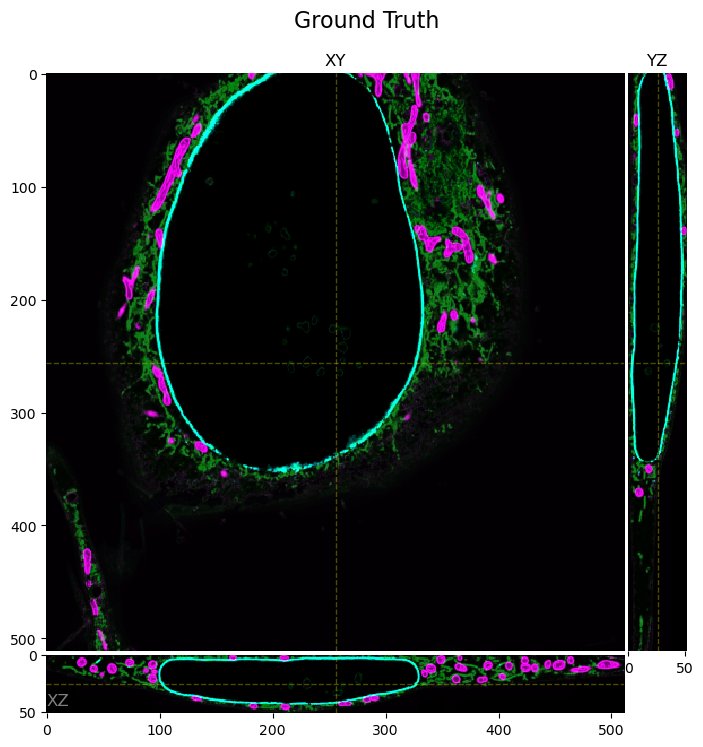

In [8]:
from microsim.util import ortho_plot

ground_truth = sim.ground_truth()
ortho_plot(ground_truth, title="Ground Truth", cmap=["cyan", "green", "magenta"])

Emission Image

In [10]:
em_img = sim.emission_flux() # shape (C, F, Z, Y, X)
em_img_reduced = em_img.sum(axis=0) # shape (F, Z, Y, X)

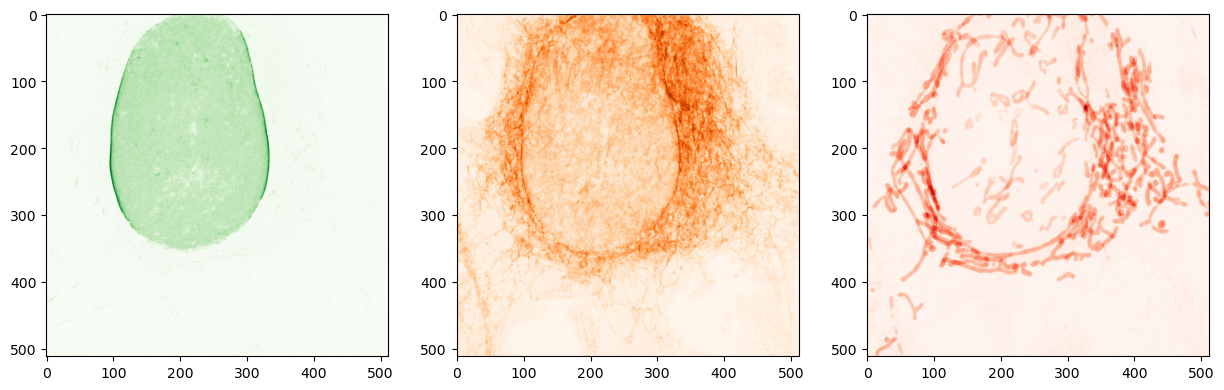

In [15]:
_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(em_img_reduced[0].sum(axis=0), cmap="Greens")
ax[1].imshow(em_img_reduced[1].sum(axis=0), cmap="Oranges")
ax[2].imshow(em_img_reduced[2].sum(axis=0), cmap="Reds")

Optical Image

In [19]:
optical_img = sim.optical_image() # shape (C, Z, Y, X)
optical_img_reduced = optical_img.sum(axis=0) # shape (Z, Y, X)

INFO:root:Rendering channel DetectBand1 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 409.0nm (x0.01)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand2 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 411.5nm (x0.04)
INFO:root:>>>> PSF @ 413.5nm (x0.05)
INFO:root:>>>> PSF @ 415.5nm (x0.08)
INFO:root:>>>> PSF @ 418.1nm (x0.17)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand3 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 421.5nm (x0.21)
INFO:root:>>>> PSF @ 423.5nm (x0.29)
INFO:root:>>>> PSF @ 425.5nm (x0.41)
INFO:root:>>>> PSF @ 428.1nm (x0.90)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand4 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 431.5nm (x0.98)
INFO:root:>>>> PSF @ 433.5nm (x1.28)
INFO:root:>>>> PSF @ 435.5nm (x1.66)
INFO:root:>>>> PSF @ 438.1nm (x3.31)
INFO:root:>> fluor 

In [17]:
optical_img_per_fluor = sim.optical_image_per_fluor() # shape (C, F, Z, Y, X)
optical_img_per_fluor_reduced = optical_img_per_fluor.sum(axis=0) # shape (F, Z, Y, X)

INFO:root:Rendering channel DetectBand1 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 409.0nm (x0.01)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand2 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 411.5nm (x0.04)
INFO:root:>>>> PSF @ 413.5nm (x0.05)
INFO:root:>>>> PSF @ 415.5nm (x0.08)
INFO:root:>>>> PSF @ 418.1nm (x0.17)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand3 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 421.5nm (x0.21)
INFO:root:>>>> PSF @ 423.5nm (x0.29)
INFO:root:>>>> PSF @ 425.5nm (x0.41)
INFO:root:>>>> PSF @ 428.1nm (x0.90)
INFO:root:>> fluor EGFP
INFO:root:>> fluor mScarlet
INFO:root:Rendering channel DetectBand4 -----------------
INFO:root:>> fluor mTagBFP2
INFO:root:>>>> PSF @ 431.5nm (x0.98)
INFO:root:>>>> PSF @ 433.5nm (x1.28)
INFO:root:>>>> PSF @ 435.5nm (x1.66)
INFO:root:>>>> PSF @ 438.1nm (x3.31)
INFO:root:>> fluor 

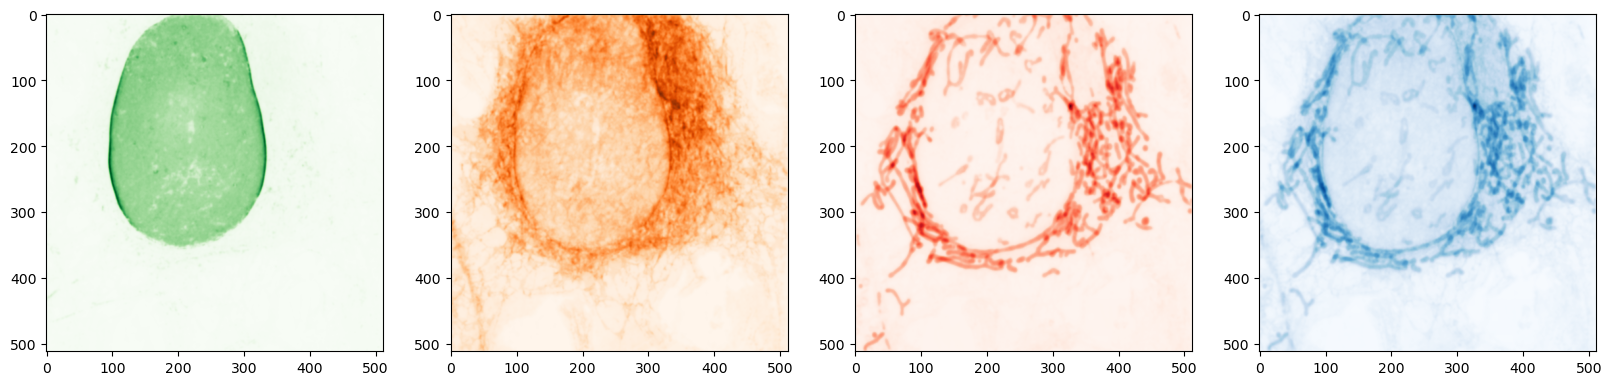

In [21]:
_, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(optical_img_per_fluor_reduced[0].sum(axis=0), cmap="Greens")
ax[1].imshow(optical_img_per_fluor_reduced[1].sum(axis=0), cmap="Oranges")
ax[2].imshow(optical_img_per_fluor_reduced[2].sum(axis=0), cmap="Reds")
ax[3].imshow(optical_img_reduced.sum(axis=0), cmap="Blues")

Digital Image

In [25]:
digital_img = sim.digital_image(optical_img) # shape (C, Z, Y, X)
digital_img_reduced = digital_img.sum(axis=0) # shape (Z, Y, X)

NOTE: there's no available function for per fluotophore digital here ... <br>
It can be easily computed though

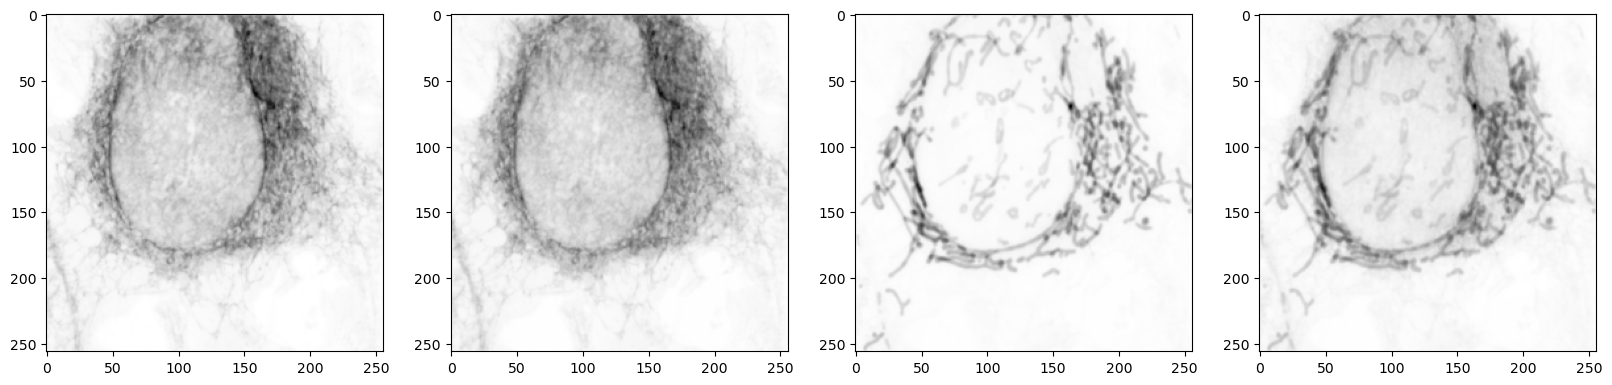

In [27]:
_, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(digital_img[10].sum(axis=0), cmap="Grays")
ax[1].imshow(digital_img[15].sum(axis=0), cmap="Grays")
ax[2].imshow(digital_img[20].sum(axis=0), cmap="Grays")
ax[3].imshow(digital_img_reduced.sum(axis=0), cmap="Grays")